In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load train and validation dataframe

In [3]:
train = pd.read_csv('glaucoma_train.csv')
val = pd.read_csv('glaucoma_val.csv')
train

,filename,label,path,label_encoded
0,07_g.jpg,glaucoma,HRF_GLAUCOMA/07_g.jpg,1
1,05_g.jpg,glaucoma,HRF_GLAUCOMA/05_g.jpg,1
2,14_g.jpg,glaucoma,HRF_GLAUCOMA/14_g.jpg,1
3,01_g.jpg,glaucoma,HRF_GLAUCOMA/01_g.jpg,1
4,06_g.jpg,glaucoma,HRF_GLAUCOMA/06_g.jpg,1
...,...,...,...,...
1484,N-21-L.jpg,normal,RIMONE_r3_CROPPED/N-21-L.jpg,0
1485,N-55-L.jpg,normal,RIMONE_r3_CROPPED/N-55-L.jpg,0
1486,N-43-L.jpg,normal,RIMONE_r3_CROPPED/N-43-L.jpg,0
1487,N-67-L.jpg,normal,RIMONE_r3_CROPPED/N-67-L.jpg,0


## Detect imbalance classes

In [4]:
train.groupby('label').count()

,filename,path,label_encoded
label,,,
glaucoma,459,459,459
normal,1030,1030,1030


## Make sure all images can be opened

In [5]:
for path in train['path']:
    img = Image.open(path)

## Construct balance training set
- Oversample minority class
- Undersample majority class

In [6]:
NUM_SAMPLE = 900
train_balanced = pd.DataFrame(columns=train.columns)

for label in train['label'].unique():
    sub_df = train[train['label'] == label]
    sub_df_fixed = sub_df.copy()

    duplicate_n = int(NUM_SAMPLE / len(sub_df))
    for _ in range(duplicate_n): sub_df = sub_df.append(sub_df_fixed, ignore_index=True)

    sub_df = sub_df.sample(NUM_SAMPLE)
    train_balanced = train_balanced.append(sub_df, ignore_index=True)

train_balanced

,filename,label,path,label_encoded
0,Im305.jpg,glaucoma,RIMONE_r2/Glaucoma and glaucoma suspicious/Im3...,1
1,2.jpg,glaucoma,DR_HAGIS_GLAUCOMA/2.jpg,1
2,Im268.jpg,glaucoma,RIMONE_r2/Glaucoma and glaucoma suspicious/Im2...,1
3,11_g.jpg,glaucoma,HRF_GLAUCOMA/11_g.jpg,1
4,drishtiGS_083.png,glaucoma,Drishti/drishtiGS_083.png,1
...,...,...,...,...
1795,Im086.bmp,normal,RIMONE_r1/Normal/Im086.bmp,0
1796,Im0257_ORIGA.jpg,normal,ORIGA_NORMAL/Im0257_ORIGA.jpg,0
1797,NL_011.png,normal,kaggle_ds/1_normal/NL_011.png,0
1798,drishtiGS_095.png,normal,Drishti/drishtiGS_095.png,0


In [7]:
NUM_TRAIN = len(train_balanced)
train_balanced = train_balanced.sample(NUM_TRAIN)

## Load dataframe data into TensorFlow Datasets `tf.data.Dataset`

In [8]:
train_ds = tf.data.Dataset.from_tensor_slices((train_balanced['path'], train_balanced['label_encoded'].astype(int))).cache().shuffle(NUM_TRAIN)
val_ds = tf.data.Dataset.from_tensor_slices((val['path'], val['label_encoded'])).cache()

IMG_DIM = 380

def import_image(path, label):
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [IMG_DIM, IMG_DIM])

    return img, label

train_ds = train_ds.map(import_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(import_image, num_parallel_calls=AUTOTUNE)

tf.Tensor(0.0, shape=(), dtype=float32)
1.0


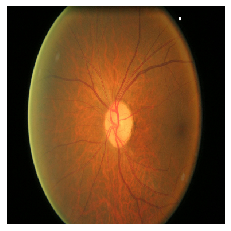

In [9]:
for img, label in train_ds.take(1):
    print(label)
    plt.imshow(img)
    plt.axis('off')
    print(np.max(img.numpy()))

## Apply augmentation on train set

In [10]:
ROTATE_ANGLE = 10/180 * math.pi

def image_augment(img, label):
    batch_size = tf.shape(img)[0]

    img = tf.image.random_flip_left_right(img)
    img = tfa.image.rotate(img, tf.random.uniform([batch_size], minval=-ROTATE_ANGLE, maxval=ROTATE_ANGLE)[0])
    
    img = tf.image.resize(img, [500, 500])
    img = tf.image.random_crop(img, [batch_size, IMG_DIM, IMG_DIM, 3])

    img = tfa.image.random_cutout(img, (100, 100))

    return img, label

In [11]:
BATCH_SIZE = 32

train_ds = train_ds.batch(BATCH_SIZE).map(image_augment)
val_ds = val_ds.batch(BATCH_SIZE)

tf.Tensor(1.0, shape=(), dtype=float32)


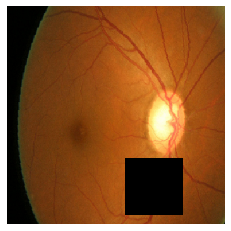

In [12]:
for img, label in train_ds.take(1):
    print(label[0])
    plt.imshow(img[0])
    plt.axis('off')

## Load model from TensorFlow Hub

In [13]:
TF_HUB_MODEL = 'https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1'
hub_layer = hub.KerasLayer(TF_HUB_MODEL, trainable=False)

model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build([None, IMG_DIM, IMG_DIM, 3])  # Batch input shape.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 16)                28688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,702,521
Trainable params: 28,705
Non-trainable params: 17,673,816
_________________________________________________________________


## Compile model

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['acc']
)

## Write custom callback to save history across all trainings

In [16]:
history = {
    'loss': [],
    'acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # save logs
        for key in logs.keys():
            history[key].append(logs[key])
        # save learning rate
        history['lr'].append(self.model.optimizer.learning_rate.numpy())
        
saveHistory = SaveHistoryCallback()

## Run 1 epoch to warm up the classification layer

In [17]:
_ = model.fit(
    train_ds,
    epochs=1,
    validation_data=val_ds,
    callbacks=[saveHistory]
)

57/57 [==============================] - 27s 470ms/step - loss: 0.6828 - acc: 0.5594 - val_loss: 0.6618 - val_acc: 0.6200


## Unfreeze previous layers to train the whole model

In [18]:
hub_layer.trainable = True
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1792)              17673816  
_________________________________________________________________
dense (Dense)                (None, 16)                28688     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 17,702,521
Trainable params: 17,577,321
Non-trainable params: 125,200
_________________________________________________________________


## Apply exponential decay to learning rate

In [19]:
def scheduler(epoch, lr): return lr * tf.math.exp(-0.05)
lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

_ = model.fit(
    train_ds,
    epochs=10,
    validation_data=val_ds,
    callbacks=[saveHistory, lrScheduler],
)

Epoch 1/10
57/57 [==============================] - 25s 439ms/step - loss: 0.6498 - acc: 0.6344 - val_loss: 0.6381 - val_acc: 0.6550
Epoch 2/10
57/57 [==============================] - 25s 440ms/step - loss: 0.6264 - acc: 0.6672 - val_loss: 0.6256 - val_acc: 0.6450
Epoch 3/10
57/57 [==============================] - 26s 449ms/step - loss: 0.6076 - acc: 0.6828 - val_loss: 0.6203 - val_acc: 0.6550
Epoch 4/10
57/57 [==============================] - 26s 452ms/step - loss: 0.5927 - acc: 0.6917 - val_loss: 0.6149 - val_acc: 0.6600
Epoch 5/10
57/57 [==============================] - 25s 447ms/step - loss: 0.5854 - acc: 0.7044 - val_loss: 0.6041 - val_acc: 0.6550
Epoch 6/10
57/57 [==============================] - 26s 451ms/step - loss: 0.5752 - acc: 0.7217 - val_loss: 0.5994 - val_acc: 0.6650
Epoch 7/10
57/57 [==============================] - 26s 448ms/step - loss: 0.5664 - acc: 0.7061 - val_loss: 0.5862 - val_acc: 0.6800
Epoch 8/10
57/57 [==============================] - 26s 448ms/step - 

In [20]:
history

{'loss': [0.6828033924102783,
  0.6498193740844727,
  0.6263754367828369,
  0.6076187491416931,
  0.5927038192749023,
  0.5854009985923767,
  0.575189471244812,
  0.5664209723472595,
  0.5581166744232178,
  0.5535627603530884,
  0.5504869818687439],
 'acc': [0.5594444274902344,
  0.6344444155693054,
  0.6672222018241882,
  0.6827777624130249,
  0.6916666626930237,
  0.7044444680213928,
  0.721666693687439,
  0.7061111330986023,
  0.7255555391311646,
  0.730555534362793,
  0.7283333539962769],
 'val_loss': [0.661794126033783,
  0.6380734443664551,
  0.6256334781646729,
  0.6203332543373108,
  0.6149407029151917,
  0.6041061878204346,
  0.599373459815979,
  0.5862001180648804,
  0.5837950110435486,
  0.5822013020515442,
  0.5849788784980774],
 'val_acc': [0.6200000047683716,
  0.6549999713897705,
  0.6449999809265137,
  0.6549999713897705,
  0.6600000262260437,
  0.6549999713897705,
  0.6650000214576721,
  0.6800000071525574,
  0.675000011920929,
  0.6899999976158142,
  0.665000021457672

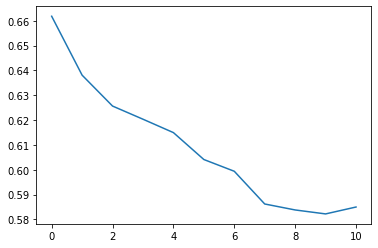

In [21]:
plt.plot(np.arange(len(history['val_loss'])), history['val_loss'])

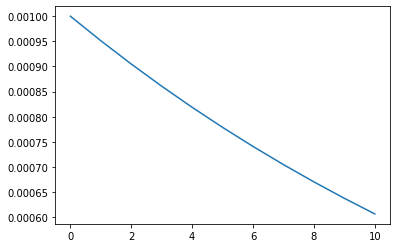

In [24]:
plt.plot(np.arange(len(history['lr'])), history['lr'])